### Notes on `hist` package
Author: Toby Dixon (toby.dixon.23@ucl.ac.uk)

This notebook contains a bunch of useful information and examples for the hist package I wanted to keep track of. Most of the information is in the form of a conversion from ROOT --> hist

In [5]:
import re
import pandas as pd
import uproot
import copy
import hist
import math
from legend_plot_style import LEGENDPlotStyle as lps
from datetime import datetime, timezone
from scipy.stats import poisson
from scipy.stats import norm
lps.use('legend')
import matplotlib.pyplot as plt
import numpy as np
import tol_colors as tc
from hist import Hist
import json
from legendmeta import LegendMetadata
import warnings
from iminuit import Minuit, cost
from scipy.stats import expon
from scipy.stats import truncnorm
from matplotlib.backends.backend_pdf import PdfPages
from numba import jit
import utils

#### Creating a hist object
First we make an empty hist with 10 bins from 0 to 10. There are a bunch of methods to extract the information.
1. `values,bins = histo.to_numpy()` : Gets the bin contents and lower bin edges (plus the last upper edge), equivalently you can call `histo.values()` and `histo.axes.edges[0]`, the overflow bins are not included!
2. `histo.axes.centers[0]`: Get the bin centers
3. `histo.size` gives the total size including the two overflow bins

In [6]:
histo =( Hist.new.Reg(10, 0, 10).Double())
print(histo)

## you can easily extract the data to numpy array
values,bins=histo.to_numpy()

print("Values = {} (size = {})".format(values,len(values)))
print("bins = {}   (size = {})".format(bins,len(bins)))

## alternatively you can get the values with hist.values() and the bin edges with:

edges = histo.axes.edges[0]
print("bin edges = {} (size = {})".format(edges,len(edges)))
print("size = {}".format(histo.size))
## to get the bin centers and widths

centers = histo.axes.centers[0]
widths= np.diff(histo.axes.edges[0])
print("Centers = {} (size  = {})".format(centers,len(centers)))
print("Width =  {} (size = {})".format(widths,len(widths)))


              ┌──────────────────────────────────────────────────────────────┐
[-inf,   0) 0 │                                                              │
[   0,   1) 0 │                                                              │
[   1,   2) 0 │                                                              │
[   2,   3) 0 │                                                              │
[   3,   4) 0 │                                                              │
[   4,   5) 0 │                                                              │
[   5,   6) 0 │                                                              │
[   6,   7) 0 │                                                              │
[   7,   8) 0 │                                                              │
[   8,   9) 0 │                                                              │
[   9,  10) 0 │                                                              │
[  10, inf) 0 │                                     

In the hist object the values is an array of length number of bins, the overflow bins are not included. The edges is one longer, these always refer to the lower bin edge.  

#### Setting some bin contents
You can set the bin content in some different ways:
1. `hist[i]=a`
2. `hist[2j]=a`
For the first method its important to note that bin [0] is the first main histo bin, doesnt include overflow
Here the complex number means to find the bin containing 2.

In [7]:
## lets set bin 4 (the 5th bin of the one from 4-5) to 10 and the bin containing 5.2 (5-6) to 15
histo[4]=10
histo[5.2j]=15

print(histo)

               ┌─────────────────────────────────────────────────────────────┐
[-inf,   0) 0  │                                                             │
[   0,   1) 0  │                                                             │
[   1,   2) 0  │                                                             │
[   2,   3) 0  │                                                             │
[   3,   4) 0  │                                                             │
[   4,   5) 10 │████████████████████████████████████████                     │
[   5,   6) 15 │████████████████████████████████████████████████████████████ │
[   6,   7) 0  │                                                             │
[   7,   8) 0  │                                                             │
[   8,   9) 0  │                                                             │
[   9,  10) 0  │                                                             │
[  10, inf) 0  │                                    

#### Rebinning
You can rebin the histogram with a type of slicing. You simply do:
`hist_rebin=histo[hist.rebin(N)]`
If you try to rebin by a factor not dividing the number of bins some of the end of the histogram will be moved into overflow.

In [8]:
print("1 keV =  \n \n ",histo)
print("2 keV = \n \n ",histo[hist.rebin(2)])
print("3 keV = \n \n ",histo[hist.rebin(3)])



1 keV =  
 
                 ┌─────────────────────────────────────────────────────────────┐
[-inf,   0) 0  │                                                             │
[   0,   1) 0  │                                                             │
[   1,   2) 0  │                                                             │
[   2,   3) 0  │                                                             │
[   3,   4) 0  │                                                             │
[   4,   5) 10 │████████████████████████████████████████                     │
[   5,   6) 15 │████████████████████████████████████████████████████████████ │
[   6,   7) 0  │                                                             │
[   7,   8) 0  │                                                             │
[   8,   9) 0  │                                                             │
[   9,  10) 0  │                                                             │
[  10, inf) 0  │                      

##### Variable binning / rebinning
So far I did'nt find a great solution for variable binning / rebinning, here is my hack

In [29]:
### create the variable binned histo
print(histo)
edges = [0,4,6,7,9,10]
histo_var =( Hist.new.Variable(edges).Double())
for i in range(histo.size-2):
    cent = histo.axes.centers[0][i]
 
    histo_var[cent*1j]+=histo.values()[i]


                  ┌──────────────────────────────────────────────────────────┐
[-inf,   0) 0     │                                                          │
[   0,   1) 0     │                                                          │
[   1,   2) 0     │                                                          │
[   2,   3) 0     │                                                          │
[   3,   4) 0     │                                                          │
[   4,   5) 50.53 │██████████████████████████████████████                    │
[   5,   6) 75.8  │█████████████████████████████████████████████████████████ │
[   6,   7) 0     │                                                          │
[   7,   8) 0     │                                                          │
[   8,   9) 0     │                                                          │
[   9,  10) 0     │                                                          │
[  10, inf) 0     │                                 

In [27]:
print(histo_var)

                  ┌──────────────────────────────────────────────────────────┐
[-inf,   0) 0     │                                                          │
[   0,   4) 0     │                                                          │
[   4,   6) 126.3 │█████████████████████████████████████████████████████████ │
[   6,   7) 0     │                                                          │
[   7,   9) 0     │                                                          │
[   9,  10) 0     │                                                          │
[  10, inf) 0     │                                                          │
                  └──────────────────────────────────────────────────────────┘


#### Scaling
Seems you should loop over the values (could be slow)

In [10]:
scale=5.053
print(histo)
for i in range(histo.size-2):
    histo[i]*=scale
print(histo)

               ┌─────────────────────────────────────────────────────────────┐
[-inf,   0) 0  │                                                             │
[   0,   1) 0  │                                                             │
[   1,   2) 0  │                                                             │
[   2,   3) 0  │                                                             │
[   3,   4) 0  │                                                             │
[   4,   5) 10 │████████████████████████████████████████                     │
[   5,   6) 15 │████████████████████████████████████████████████████████████ │
[   6,   7) 0  │                                                             │
[   7,   8) 0  │                                                             │
[   8,   9) 0  │                                                             │
[   9,  10) 0  │                                                             │
[  10, inf) 0  │                                    

#### Plotting

Text(0, 0.5, 'counts')

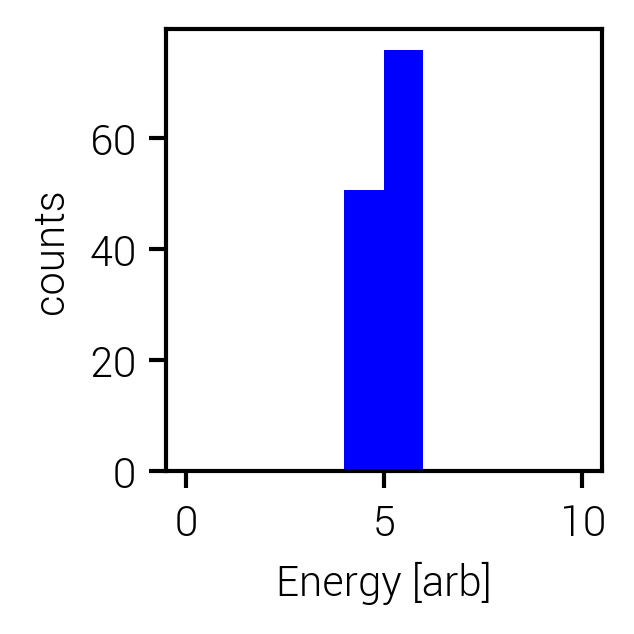

In [11]:
## can plot quite simply

style = {
    "yerr": False,
    "flow": None,
    "lw": 0.8,
}

fig, ax = lps.subplots(1, 1, figsize=(2,2), sharex=True, gridspec_kw = {'hspace': 0})

histo.plot(ax=ax, **style,color="blue",histtype="fill")
ax.set_xlabel("Energy [arb]")
ax.set_ylabel("counts")

#### 2D histograms
We can make a 2D histogram

In [12]:
histo_2D =( Hist.new.Regular(10, 0, 10).Regular(10, 0, 10)).Double()
print(histo_2D)


Hist(
  Regular(10, 0, 10, label='Axis 0'),
  Regular(10, 0, 10, label='Axis 1'),
  storage=Double())


Text(0, 0.5, 'counts')

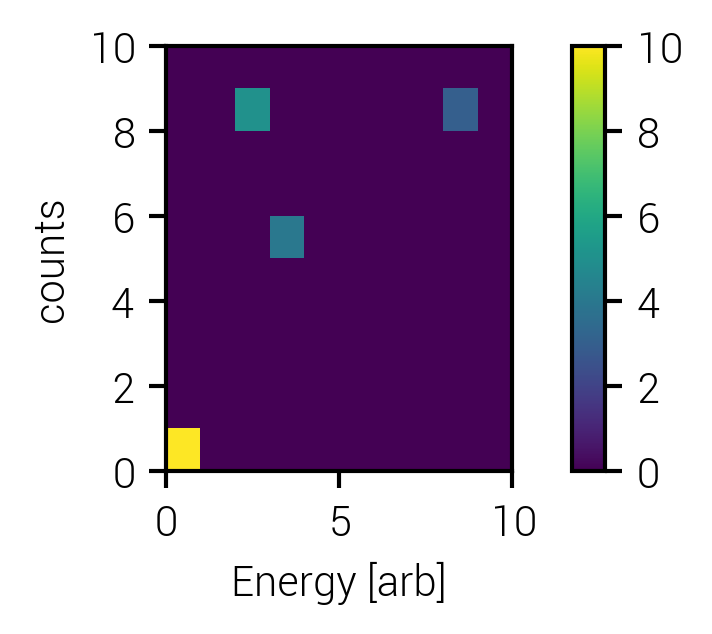

In [13]:
### set the values as (first index is x second y)
histo_2D[0,0]=10
histo_2D[3,5]=4
histo_2D[2,8]=5
histo_2D[8,8]=3
fig, ax = lps.subplots(1, 1, figsize=(2,2), sharex=True, gridspec_kw = {'hspace': 0})

histo_2D.plot(ax=ax)
ax.set_xlabel("Energy [arb]")
ax.set_ylabel("counts")

In [14]:
w,x,y= histo_2D.to_numpy()
print("weights = \n {} \n (shape = {})".format(w,np.shape(w)))
print("x = {} (shape = {})".format(x,len(x)))

weights = 
 [[10.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  5.  0.]
 [ 0.  0.  0.  0.  0.  4.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  3.  0.]
 [ 0.  0.  0.  0.  0.  0.  0.  0.  0.  0.]] 
 (shape = (10, 10))
x = [ 0.  1.  2.  3.  4.  5.  6.  7.  8.  9. 10.] (shape = 11)


#### summed projection


In [15]:

sum_project= utils.project_sum(histo_2D)
print(sum_project)

                ┌────────────────────────────────────────────────────────────┐
[-inf,   0) 0   │                                                            │
[   0,   1) 5   │███████████████████████████████████████████████████████████ │
[   1,   2) 5   │███████████████████████████████████████████████████████████ │
[   2,   3) 0   │                                                            │
[   3,   4) 0   │                                                            │
[   4,   5) 0   │                                                            │
[   5,   6) 0   │                                                            │
[   6,   7) 0   │                                                            │
[   7,   8) 0   │                                                            │
[   8,   9) 2   │███████████████████████▋                                    │
[   9,  10) 2   │███████████████████████▋                                    │
[  10,  11) 2.5 │█████████████████████████████▌     